# ChatGPT SENTIMENT ANALYSIS

**Import Libraries**

In [1]:
#Install Packages
!pip install app-store-scraper
!pip install wordcloud

#Import Libraries
from app_store_scraper import AppStore

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import json,os,uuid
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 983.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take int

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Data Collection**

In [2]:
#Collect all the ChatGPT reviews from App Store
a_reviews = AppStore('us','chatgpt','6448311069')
a_reviews.review(sleep=1)

In [3]:
data = pd.DataFrame(np.array(a_reviews.reviews),columns=['review'])
data = data.join(pd.DataFrame(data.pop('review').tolist()))
data.head()

,date,review,rating,isEdited,title,userName
0,2023-09-20 15:54:11,"Oh my gosh, I cannot explain how much I’ve use...",5,False,Always quick!,MORE FREE PAINTINGS!!!
1,2023-09-10 02:45:51,Up to this point I’ve mostly been using ChatGP...,4,False,Much more accessible for blind users than the ...,PDXJavaJunkie
2,2023-07-11 12:24:19,I’ve been a user since it’s initial roll out a...,4,False,"Much anticipated, wasn’t let down.",Tinny tower addicted
3,2023-05-27 21:57:27,"I recently downloaded the app and overall, it'...",4,False,"4.5 stars, here’s why",Would Po
4,2023-10-09 14:12:31,Once you understand how to input and work with...,5,False,Absolute game changer… astounding!,4danapaige


In [4]:
data.shape

(8148, 6)

In [5]:
data.drop(['isEdited','userName'],axis=1,inplace=True) #Delete columns
data = data[['date','title','review','rating']] #Rearrange columns
data.head()

,date,title,review,rating
0,2023-09-20 15:54:11,Always quick!,"Oh my gosh, I cannot explain how much I’ve use...",5
1,2023-09-10 02:45:51,Much more accessible for blind users than the ...,Up to this point I’ve mostly been using ChatGP...,4
2,2023-07-11 12:24:19,"Much anticipated, wasn’t let down.",I’ve been a user since it’s initial roll out a...,4
3,2023-05-27 21:57:27,"4.5 stars, here’s why","I recently downloaded the app and overall, it'...",4
4,2023-10-09 14:12:31,Absolute game changer… astounding!,Once you understand how to input and work with...,5


In [6]:
#Storing Data
data.to_csv('chatgpt_reviews.csv',index=False)

**Exploratory Data Analysis**

In [7]:
data = pd.read_csv('chatgpt_reviews.csv')

In [8]:
data.shape

(8148, 4)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8148 entries, 0 to 8147
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    8148 non-null   object
 1   title   8148 non-null   object
 2   review  8148 non-null   object
 3   rating  8148 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 254.8+ KB


In [10]:
data.describe()

,rating
count,8148.000000
mean,4.101129
std,1.476574
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [11]:
data.describe(include='object')

,date,title,review
count,8148,8148,8148
unique,8143,6422,7966
top,2023-05-19 03:27:04,Amazing,Good
freq,2,112,13


**Analysis of Rating column**

In [13]:
#Rating Distribution
data['rating'].value_counts().sort_index()

1    1174
2     330
3     477
4     684
5    5483
Name: rating, dtype: int64

In [14]:
data['rating'].value_counts(normalize=True).mul(100).round(2).sort_index()

1    14.41
2     4.05
3     5.85
4     8.39
5    67.29
Name: rating, dtype: float64

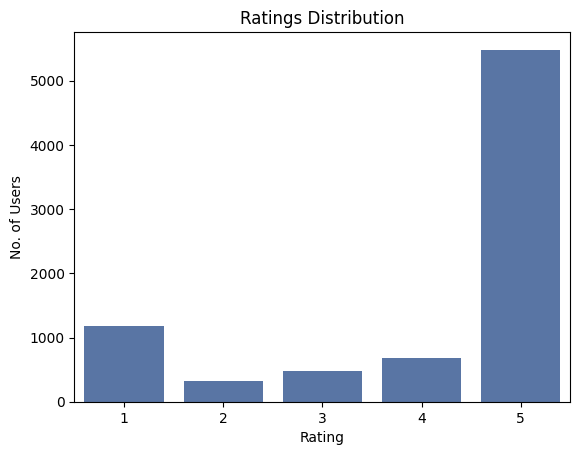

In [15]:
#Plot
palette = "deep"
sns.set_palette(palette)

sns.countplot(data=data, x='rating')

plt.xlabel('Rating')
plt.ylabel('No. of Users')
plt.title('Ratings Distribution')

plt.show()

**Data Preprocessing**

In [16]:
#Find no. of missing values in each column
data.isnull().sum().sort_values(ascending=False)

date      0
title     0
review    0
rating    0
dtype: int64

In [17]:
#Combine Review Time and Review
data['complete_review'] = data['title'] +' .'+data['review']

In [18]:
#Drop some columns which we won't use for sentiment analysis of review
remove_cols = ['date','review','title']
data = data.drop(remove_cols,axis='columns')

In [19]:
data.head()

,rating,complete_review
0,5,"Always quick! .Oh my gosh, I cannot explain ho..."
1,4,Much more accessible for blind users than the ...
2,4,"Much anticipated, wasn’t let down. .I’ve been ..."
3,4,"4.5 stars, here’s why .I recently downloaded t..."
4,5,Absolute game changer… astounding! .Once you u...


1. Convert all the reviews to lowercase




In [20]:
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['complete_review'].head()

0    always quick! .oh my gosh, i cannot explain ho...
1    much more accessible for blind users than the ...
2    much anticipated, wasn’t let down. .i’ve been ...
3    4.5 stars, here’s why .i recently downloaded t...
4    absolute game changer… astounding! .once you u...
Name: complete_review, dtype: object

2. Remove Punctuation

In [21]:
data['complete_review'] = data['complete_review'].str.replace('[^\w\s]','')

3. Remove Emojis

In [22]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
data['complete_review'] = data['complete_review'].apply(lambda x: remove_emoji(x))

4. Remove Stopwords

In [23]:
stop = stopwords.words('english')
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

5. Apply Lemmatization

In [24]:
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])
data['complete_review']= data['complete_review'].apply(space)

6. Remove certain words

In [25]:
words_to_remove = ['chatgpt','app','chatgpts','chat','gpt','iphone','ipad','gpt4','phone','number','ai','use','io']
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in words_to_remove))

7. Map ratings to positive, negative & neutral sentiment

0 will represent negative sentiment

1 will represent neutral sentiment

2 will represent positive sentiment

In [26]:
data['sentiment'] = data['rating'].apply(lambda rating: 2 if rating > 3 else (1 if rating == 3 else 0))
data.head(5)

,rating,complete_review,sentiment
0,5,always quick oh gosh can not explain much I ve...,2
1,4,much accessible blind user web version point I...,2
2,4,much anticipate be not let I ve user since ini...,2
3,4,45 star here recently download overall great p...,2
4,5,absolute game changer astounding understand in...,2


In [27]:
data['sentiment'].value_counts(normalize=True).mul(100).round(2)

2    75.69
0    18.46
1     5.85
Name: sentiment, dtype: float64

Data is Imbalanced as about 76% of sentiment is positive, 18% is negative and 6% is neutral.

**Reviews Analysis**

In [34]:
import os
print(os.getcwd())


/content


In [36]:
from google.colab import files
uploaded = files.upload()


Saving loc.png to loc.png


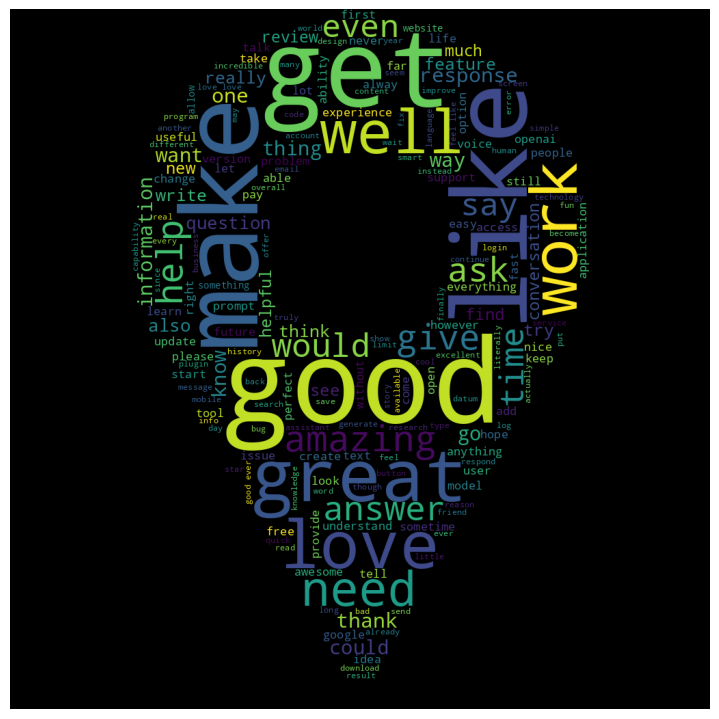

In [37]:
#Analysis of Review field
stopword = set(stopwords.words('english'))
text = " ".join(review for review in data.complete_review)
mask = np.array(Image.open("./loc.png"))
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10, mask=mask).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('review_sentiment.png')
plt.show()

In [38]:
#positive negative & neutral sentiment:
positive = data[data['sentiment'] == 2]
negative = data[data['sentiment'] == 0]
neutral = data[data['sentiment'] == 1]

In [40]:
from google.colab import files
uploaded = files.upload()


Saving thumbs_up.png to thumbs_up.png


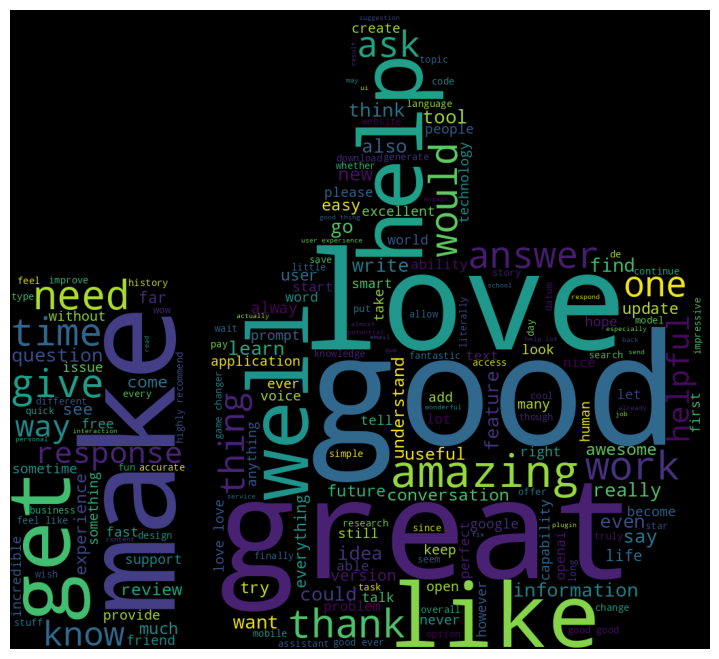

In [41]:
#Positive Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in positive.complete_review)
mask = np.array(Image.open("./thumbs_up.png"))
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10, mask=mask).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('positive_sentiment.png')
plt.show()

In [42]:
from google.colab import files
uploaded = files.upload()

Saving thumbs_down.png to thumbs_down.png


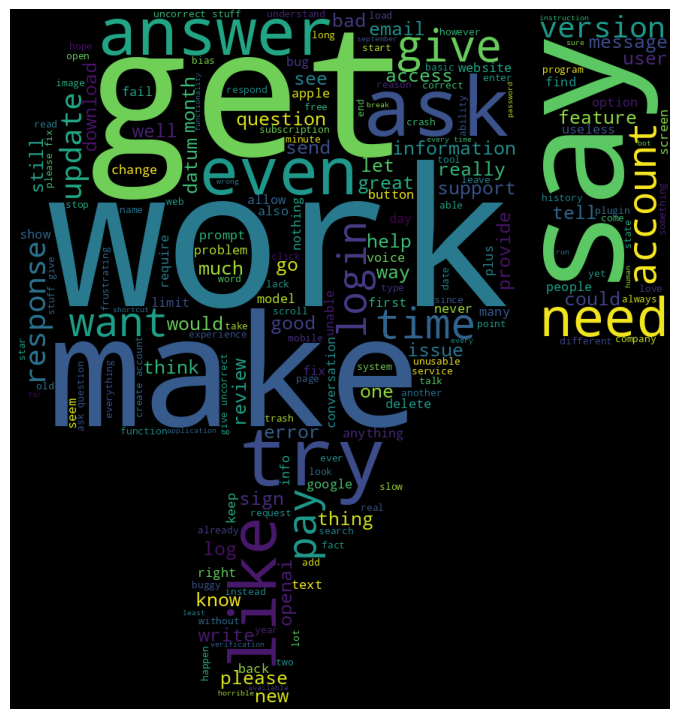

In [43]:
#Negative Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in negative.complete_review)
mask = np.array(Image.open("./thumbs_down.png"))
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10, mask=mask).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('negative_sentiment.png')
plt.show()

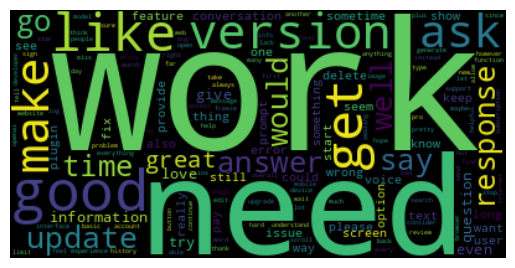

In [44]:
#Neutral Sentiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in neutral.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()